### Load to mongo DB

In [1]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.impute import SimpleImputer
import re
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from itertools import chain
import ast

In [2]:
client = MongoClient("mongodb://localhost:27017/")
db = client['test']
collection = db['indeed']

In [3]:
# Fetch all data from the collection
data = list(collection.find())

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [4]:
df.sample()

,_id,ID,Job,Jobs_Group,Profile,Remote,Company,Location,City,State,Salary,Frecuency_Salary,Low_Salary,High_Salary,Mean_Salary,Skills,Unnamed: 15,Rating,Job_description
114970,669bf9dcbd7e1566806ebc32,job_eb1906d8dad2318b,SR. FINANCIAL ANALYST (TECHNICAL ACCOUNTING VA...,Financial Analyst,Senior,Hybrid,Compass Corporate,"Charlotte, NC 28217Â (Eagle Lake area)",Charlotte,NC,NaN,NaN,NaN,NaN,NaN,"['CPA', 'Bachelor', 'Access', 'Excel', 'Essbas...",NaN,3.8,Monitor financial performance and trends.


In [5]:
df['Jobs_Group'].unique()

array(['Data Analyst', 'CFO', 'Business Analyst', 'Business Intelligence',
       'Operations Analyst', 'Others', 'Data Engineer',
       'Financial Analyst', 'Analyst', 'Statistician/Mathemathics',
       'Finance', 'Controller', 'Data Scientist', 'ML/AI Engineer'],
      dtype=object)

In [6]:
df.shape

(146392, 19)

In [7]:
df.isnull().sum()

_id                      0
ID                       0
Job                      0
Jobs_Group               0
Profile              92479
Remote               89399
Company                  0
Location                26
City                 16138
State                12575
Salary               70053
Frecuency_Salary     89925
Low_Salary           84702
High_Salary          89925
Mean_Salary          89925
Skills                   0
Unnamed: 15         146392
Rating                   0
Job_description          0
dtype: int64

In [8]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146392 entries, 0 to 146391
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   _id               146392 non-null  object 
 1   ID                146392 non-null  object 
 2   Job               146392 non-null  object 
 3   Jobs_Group        146392 non-null  object 
 4   Profile           53913 non-null   object 
 5   Remote            56993 non-null   object 
 6   Company           146392 non-null  object 
 7   Location          146366 non-null  object 
 8   City              130254 non-null  object 
 9   State             133817 non-null  object 
 10  Salary            76339 non-null   object 
 11  Frecuency_Salary  56467 non-null   object 
 12  Low_Salary        61690 non-null   float64
 13  High_Salary       56467 non-null   float64
 14  Mean_Salary       56467 non-null   float64
 15  Skills            146392 non-null  object 
 16  Unnamed: 15       0 

,Low_Salary,High_Salary,Mean_Salary,Unnamed: 15,Rating
count,61690.000000,56467.000000,56467.000000,0.0,146392.000000
mean,89843.472547,119232.030435,105018.032179,NaN,3.465737
std,38809.363604,53350.596307,43921.939873,NaN,0.882952
min,10.000000,9200.000000,9200.000000,NaN,1.500000
25%,64896.200000,82976.300000,75000.000000,NaN,2.800000
50%,82800.000000,110000.000000,96650.000000,NaN,3.500000
75%,110000.000000,143000.000000,125000.000000,NaN,4.200000
max,600000.000000,600000.000000,600000.000000,NaN,5.000000


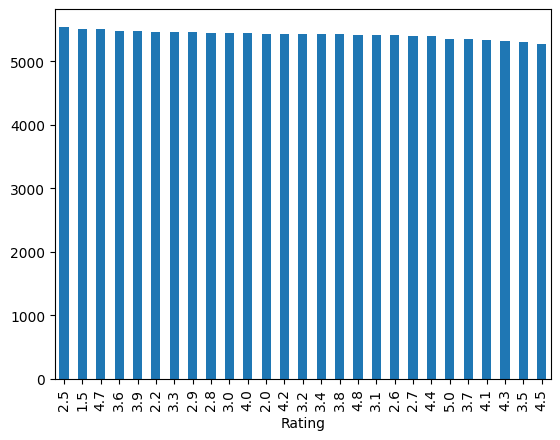

In [9]:
df['Rating'].value_counts().plot(kind='bar')
plt.show()

### pre process

In [10]:
column_drop=['_id','ID','Job','City','Salary','Frecuency_Salary','Unnamed: 15','Location',]
df.drop(columns=column_drop, inplace=True)

#### Company column

In [11]:
df.shape

(146392, 11)

In [12]:
df['Company'].value_counts()

Company
JPMorgan Chase & Co                     664
Amazon.com Services LLC                 603
Apple                                   596
Lockheed Martin                         525
Booz Allen Hamilton                     464
                                       ... 
NITSDATA                                  1
Ag-Analytics Technology Company, LLC      1
SoulCycle HQ                              1
EZSVS USA Inc.                            1
Home State Insurance Group, Inc.          1
Name: count, Length: 40437, dtype: int64

#### salary

In [13]:
def fill_mean_salary(row):
    if pd.notnull(row['Low_Salary']):
        if pd.notnull(row['Profile']):
            if 'Senior' in row['Profile'] or 'Lead' in row['Profile']:
                return row['Low_Salary'] * 1.2
            elif 'Junior' in row['Profile']:
                return row['Low_Salary'] * 1.09
    return row['Mean_Salary']

df['Mean_Salary'] = df.apply(fill_mean_salary, axis=1)

In [14]:
def fill_nan_salaries(salaries):
    non_null_salaries = salaries.dropna().values
    return salaries.apply(
        lambda x: np.random.choice(non_null_salaries) if pd.isnull(x) and non_null_salaries.size > 0 else x
    )

# Apply function to 'Mean_Salary' column within each job group using transform
df['Mean_Salary'] = df.groupby('Jobs_Group')['Mean_Salary'].transform(fill_nan_salaries)



In [15]:
drop_col=['Low_Salary','High_Salary']
df.drop(columns=drop_col, inplace=True)

#### State column

In [16]:
#### Profile

In [17]:
def fill_nan_profiles(row):
    if pd.isnull(row['Profile']):
        if row['Mean_Salary'] < 60000:
            return 'Junior'
        else:
            return np.random.choice(['Senior', 'Lead'])
    return row['Profile']

# Apply the function to the DataFrame
df['Profile'] = df.apply(fill_nan_profiles, axis=1)

In [18]:
df['Profile'].value_counts()

Profile
Senior    69695
Lead      64260
Junior    12437
Name: count, dtype: int64

In [19]:
### To find frequency of each skill in list

In [20]:
#### skills to respective columns

In [22]:
df.sample(2)

,Jobs_Group,Profile,Remote,Company,State,Mean_Salary,Skills,Rating,Job_description,High_skills,Low_skills
131861,Finance,Senior,NaN,Fortrea - Organic,NC,108000.0,"[CPA, Bachelor]",3.4,Conduct financial analysis and risk assessments.,2,0
139689,Controller,Lead,NaN,Schilli Plastering Co,MO,97500.0,"[CPA, Excel, Office, Bachelor]",3.3,Manage accounting operations and procedures.,4,0


In [23]:
df.shape

(146392, 11)

In [25]:
df.to_csv('Pre-process-scrap.csv', header=True)

In [24]:


# Calculate skewness and kurtosis for the temporary DataFrame
original_skewness = stats.skew(df['Rating'])
print(original_skewness)
original_kurtosis = stats.kurtosis(df['Rating'])
print(original_kurtosis)

-0.23363899932986476
-0.6543773190714166
